In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/best_mask_model.h5')

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
import time
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from PIL import Image
import io
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

**Making a real time class detector class for using webcam/device camera, making a frame around the face and predicting the captured image as per the trained model**

In [ ]:
class RealTimeMaskDetector:

    def __init__(self, model_path='/content/drive/MyDrive/best_mask_model.h5'):


        print("Loading face mask detection model...")
        self.model = keras.models.load_model(model_path)

        print("Loading face detection classifier...")
        self.face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')


        self.IMG_SIZE = (224, 224)

        self.labels = {0: 'WITH MASK', 1: 'WITHOUT MASK'}
        self.colors = {0: (0, 255, 0), 1: (0, 0, 255)}

        print("Mask detector initialized successfully!")




    def detect_and_predict_mask(self, frame):


        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = self.face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(60, 60))

        locations = []
        predictions = []

        for (x, y, w, h) in faces:

            face_roi = frame[y:y+h, x:x+w]
            face_rgb = cv2.cvtColor(face_roi, cv2.COLOR_BGR2RGB)
            face_resized = cv2.resize(face_rgb, self.IMG_SIZE)
            face_normalized = face_resized / 255.0
            face_reshaped = np.expand_dims(face_normalized, axis=0)


            prediction = self.model.predict(face_reshaped, verbose=0)[0][0]
            locations.append((x, y, w, h))
            predictions.append(prediction)

        return locations, predictions




    def draw_predictions(self, frame, locations, predictions):

        for (x, y, w, h), pred in zip(locations, predictions):

            label_idx = 1 if pred > 0.5 else 0
            label = self.labels[label_idx]
            color = self.colors[label_idx]
            confidence = pred if pred > 0.5 else 1 - pred

            cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
            text = f"{label}: {confidence:.2%}"
            text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)[0]
            text_x = x
            text_y = y - 10 if y - 10 > 10 else y + h + 20


            cv2.rectangle(frame,
                         (text_x, text_y - text_size[1] - 4), (text_x + text_size[0], text_y + 4),color, -1)

            cv2.putText(frame, text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

        return frame




    def run_webcam_detection(self):

        print("Starting webcam...")
        cap = cv2.VideoCapture(0)

        if not cap.isOpened():
            print("Failed to open webcam")
            return
        cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
        cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)

        print("Press 'q' to quit")
        print("Press 's' to save current frame")

        frame_count = 0
        fps_start_time = time.time()
        fps = 0

        while True:
            ret, frame = cap.read()
            if not ret:
                print("Failed to grab frame")
                break

            frame_count += 1
            if frame_count % 30 == 0:
                fps_end_time = time.time()
                fps = 30 / (fps_end_time - fps_start_time)
                fps_start_time = fps_end_time



            locations, predictions = self.detect_and_predict_mask(frame)


            frame = self.draw_predictions(frame, locations, predictions)

            cv2.putText(frame, f"FPS: {fps:.2f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            cv2.putText(frame, f"Faces: {len(locations)}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            cv2.imshow('Face Mask Detection', frame)


            key = cv2.waitKey(1) & 0xFF
            if key == ord('q'):
                break
            elif key == ord('s'):
                # Save current frame
                timestamp = time.strftime("%Y%m%d_%H%M%S")
                filename = f"mask_detection_{timestamp}.jpg"
                cv2.imwrite(filename, frame)
                print(f"Frame saved as {filename}")

        cap.release()
        cv2.destroyAllWindows()
        print("Webcam stopped")


**Allowing google colab to access the camera and capture the pictures**

In [ ]:
def take_photo_colab(filename='photo.jpg', quality=0.8):

    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            const video = document.createElement('video');
            video.style.display = 'block';
            video.width = 640;
            video.height = 480;
            video.autoplay = true;

            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            document.body.appendChild(div);
            div.appendChild(video);
            div.appendChild(capture);
            video.srcObject = stream;

            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();

            return canvas.toDataURL('image/jpeg', quality);
        }
        ''')

    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])

    with open(filename, 'wb') as f:
        f.write(binary)

    return filename


**Using the Google Colab Environment**

In [ ]:
class ColabMaskDetector(RealTimeMaskDetector):

    def capture_and_detect(self, show_image=True):

        print("Click 'Capture' to take a photo...")
        filename = take_photo_colab('captured_photo.jpg')

        image = cv2.imread(filename)

        if image is None:
            print("Failed to capture image")
            return None

        locations, predictions = self.detect_and_predict_mask(image)
        annotated_image = self.draw_predictions(image.copy(), locations, predictions)

        if show_image:
            print(f"\nDetected {len(locations)} face(s)")
            cv2_imshow(annotated_image)

            for i, (loc, pred) in enumerate(zip(locations, predictions)):
                label_idx = 1 if pred > 0.5 else 0
                label = self.labels[label_idx]
                confidence = pred if pred > 0.5 else 1 - pred
                print(f"Face {i+1}: {label} (Confidence: {confidence:.2%})")

        return annotated_image, locations, predictions

    def continuous_capture(self, num_captures=5, delay=2):
        results = []

        for i in range(num_captures):
            print(f"\n--- Capture {i+1}/{num_captures} ---")
            annotated_image, locations, predictions = self.capture_and_detect()

            if annotated_image is not None:
                results.append({
                    'image': annotated_image,
                    'locations': locations,
                    'predictions': predictions
                })

            if i < num_captures - 1:
                print(f"Waiting {delay} seconds before next capture...")
                time.sleep(delay)

        return results


**Using the Real Time Face Mask Detection on Google Colab only**

In [ ]:
def run_colab_detection():

    print("="*50)
    print("FACE MASK DETECTION - GOOGLE COLAB")
    print("="*50)

    detector = ColabMaskDetector('/content/drive/MyDrive/best_mask_model.h5')

    while True:
        print("\nOptions:")
        print("1. Capture single photo")
        print("2. Capture multiple photos")
        print("3. Process uploaded image")
        print("4. Exit")

        choice = input("\nEnter your choice (1-5): ")

        if choice == '1':
            detector.capture_and_detect()

        elif choice == '2':
            num = int(input("Number of captures (default 5): ") or "5")
            delay = int(input("Delay between captures in seconds (default 2): ") or "2")
            results = detector.continuous_capture(num, delay)
            print(f"\nCaptured {len(results)} images")

        elif choice == '3':
            from google.colab import files
            print("Upload an image...")
            uploaded = files.upload()
            for filename in uploaded.keys():
                print(f"\nProcessing: {filename}")
                image = cv2.imread(filename)
                locations, predictions = detector.detect_and_predict_mask(image)
                annotated = detector.draw_predictions(image.copy(), locations, predictions)
                cv2_imshow(annotated)

        elif choice == '4':
            print("Exiting...")
            break

        else:
            print("Invalid choice. Please try again.")


**Real Time Detection**

FACE MASK DETECTION - GOOGLE COLAB
Loading face mask detection model...


Loading face detection classifier...
Mask detector initialized successfully!

Options:
1. Capture single photo
2. Capture multiple photos
3. Process uploaded image
4. Exit
Click 'Capture' to take a photo...


<IPython.core.display.Javascript object>


Detected 1 face(s)


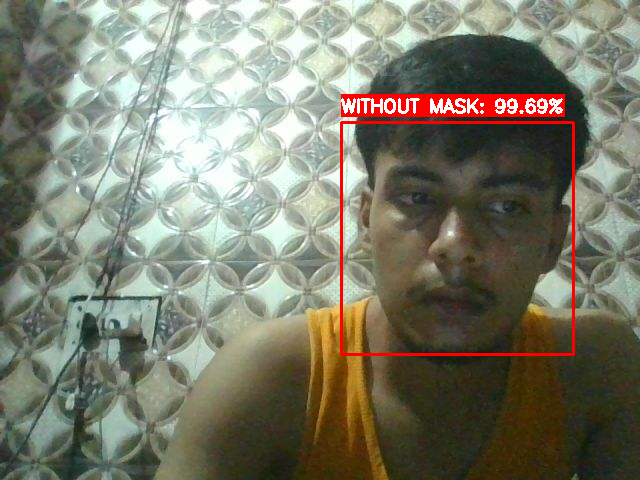

Face 1: WITHOUT MASK (Confidence: 99.69%)

Options:
1. Capture single photo
2. Capture multiple photos
3. Process uploaded image
4. Exit


In [21]:
run_colab_detection()